In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import tensorflow_probability as tfp
from skimage import transform
from scipy.interpolate import interp1d

from ipywidgets import interact, widgets, interactive_output
from IPython.display import display

# Automatic differentiation example
$$
    f(x) = sin( 2 x ) \\
    \frac{df}{dx} = 2 cos(2 x)
$$

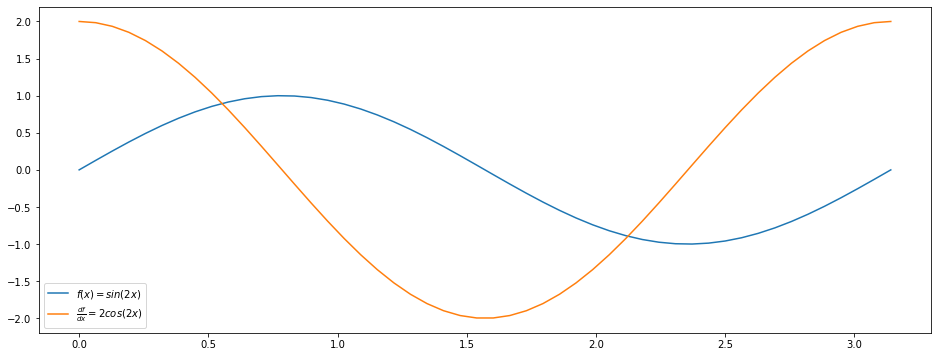

In [4]:
x = tf.Variable([np.linspace(0,np.pi)])

with tf.GradientTape() as tape:
    tape.watch(x)
    
    y = tf.sin(2*x)
    
dy_dx = tape.gradient(y, x)

plt.figure(figsize=(16,6))
plt.plot(x[0], y[0], label='$f(x) = sin(2x)$')
plt.plot(x[0], dy_dx[0], label='$\\frac{df}{dx} = 2cos(2x)$')
plt.legend()
plt.show()

# Radon transform of a kidney

In [5]:
kidney = np.loadtxt('../Data/kidney.csv', delimiter=',', skiprows=1, usecols=(0), dtype=np.float32).reshape((512,512))

#enforce to be zero on the edges
kidney[:,:10] = 50
kidney[:,-10:] = 50
kidney[:10,:] = 50
kidney[-10:,:] = 50

kidney = kidney[::16,::16]

print(kidney.shape)

(32, 32)


# Radon transform (skimage)
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5d/Radon_transform.png" />

$$
    {\displaystyle {\begin{aligned}Rf(\alpha ,s)&=\int _{-\infty }^{\infty }f(x(z),y(z))dz\\&=\int _{-\infty }^{\infty }f{\big (}(z\sin \alpha +s\cos \alpha ),(-z\cos \alpha +s\sin \alpha ){\big )}dz\end{aligned}}.}
$$

/home/vik/Programme/anaconda3/envs/ai-cpu/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


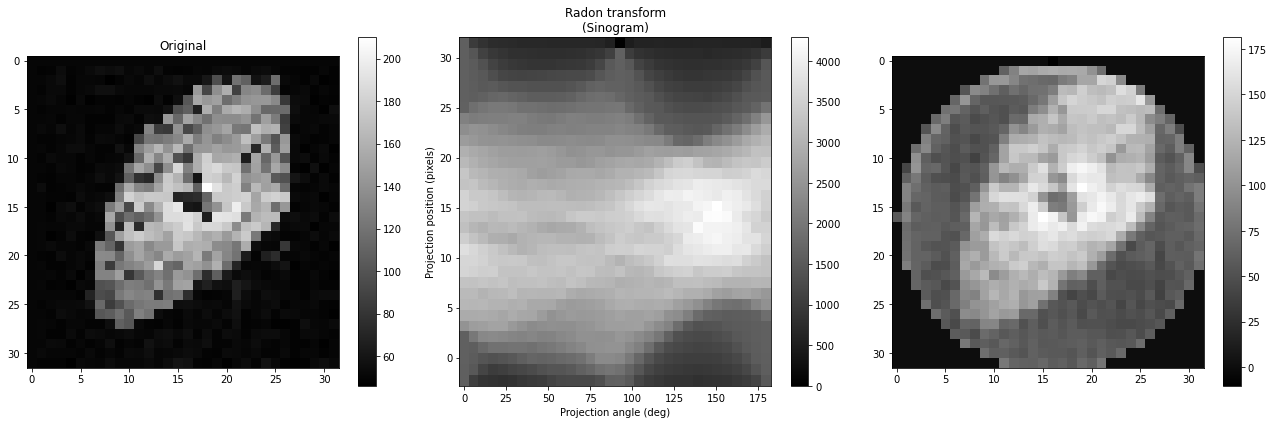

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.set_title('Original')
kid = ax1.imshow(kidney, cmap='gray')

plt.colorbar(kid, ax=ax1)

theta = np.linspace(0., 180., max(kidney.shape), endpoint=False)
sinogram = transform.radon(kidney, theta=theta)
dx, dy = 0.5 * 180.0 / max(kidney.shape), 0.5 / sinogram.shape[0]
ax2.set_title('Radon transform\n(Sinogram)')
ax2.set_xlabel('Projection angle (deg)')
ax2.set_ylabel('Projection position (pixels)')
sin = ax2.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')

plt.colorbar(sin, ax=ax2)

reconstructed = transform.iradon(sinogram, theta=theta, filter_name='ramp')
re = ax3.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax3)

fig.tight_layout()
plt.show()

# Inverse radon transform

In [7]:
def _get_fourier_filter(size, filter_name):
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                       np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    # ramp filter
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2
    
    fourier_filter = 2 * np.real(np.fft.fft(f))
    if filter_name == 'ramp':
        pass
    elif filter_name == 'shepp-logan':
        # start from first element to avoid divide by zero
        omega = np.pi * np.fft.fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == 'cosine':
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = np.fft.fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == 'hamming':
        fourier_filter *= np.fft.fftshift(np.hamming(size))
    elif filter_name == 'hann':
        fourier_filter *= np.fft.fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1
        
    return fourier_filter[:, np.newaxis]

def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)

In [8]:
angles_count = len(theta)
img_shape = sinogram.shape[0]
output_size = img_shape

# filter sinogram in the frequency domain
fourier_filter = _get_fourier_filter(img_shape, 'ramp')
projection = np.fft.fft(sinogram, axis=0) * fourier_filter
radon_image = np.real(np.fft.ifft(projection, axis=0)[:img_shape, :])

reconstructed = np.zeros_like(kidney)
radius = output_size // 2
xpr, ypr = np.mgrid[:output_size, :output_size] - radius
x = np.arange(img_shape) - img_shape // 2

for col, angle in zip(radon_image.T, np.deg2rad(theta)):
    t = ypr * np.cos(angle) - xpr * np.sin(angle)
    interpolant = interp1d(x, col, kind='linear', bounds_error=False, fill_value=0)
    reconstructed += interpolant(t)
    
kidney_reconstructed = reconstructed * np.pi / (2 * angles_count)

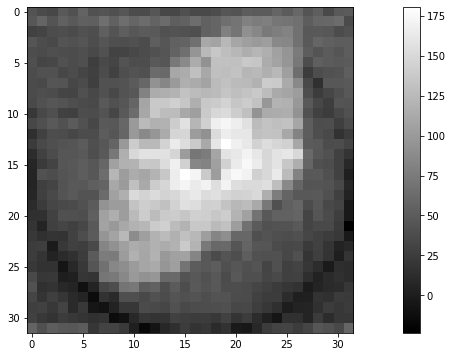

In [9]:
plt.figure(figsize=(18,6))
plt.imshow(kidney_reconstructed, cmap='gray')
plt.colorbar()
plt.show()

# Gradient of input

In [10]:
radon_image = tf.Variable(sinogram, dtype=tf.complex64)
angles_count = len(theta)
img_shape = radon_image.shape[0]
output_size = img_shape

prog = widgets.FloatProgress(
    value=0,
    min=0,
    max=5 + img_shape,
    description='Loading:',
    bar_style='info',
    orientation='horizontal'
)

display(prog)
@interact(filter_name=['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None])
def show_radon_transform(filter_name='ramp'):
    prog.bar_style = 'info'
    prog.value = 0
    fourier_filter = _get_fourier_filter(img_shape, filter_name)
    prog.value += 1

    with tf.GradientTape() as tape:
        projection = tf.transpose(tf.signal.fft(tf.transpose(radon_image))) * fourier_filter
        radon_image_filtered = tf.math.real(tf.transpose(tf.signal.ifft(tf.transpose(projection)))[:img_shape, :])

        prog.value += 1
        
        reconstructed = tf.zeros_like(kidney)
        radius = output_size // 2
        xpr, ypr = np.mgrid[:output_size, :output_size] - radius
        x = np.arange(img_shape, dtype=np.float32) - img_shape // 2

        prog.value += 1
        for col, angle in zip(tf.transpose(radon_image_filtered), np.deg2rad(theta)):
            t = np.asarray(ypr * tf.cos(angle) - xpr * tf.sin(angle), dtype=np.float32)
            interpolant = tfp.math.interp_regular_1d_grid(t, x[0], x[-1], col, fill_value=0)
            reconstructed += interpolant
            prog.value += 1

        kidney_reconstructed = reconstructed * np.pi / (2 * angles_count)
        
    df_dx = tape.jacobian(kidney_reconstructed, radon_image)
    print(df_dx.shape)
    
    prog.value += 1

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title('Sinogram')
    plt.imshow(sinogram, cmap='gray', extent=(-dx, 180 + dx, -dx, sinogram.shape[0] + dy), aspect='auto')
    plt.xlabel('')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('inverse Radon transform')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Jacobian')
    plt.imshow(tf.abs(tf.reshape(df_dx, (32*32, 32*32))))
    plt.colorbar()
    plt.show()
    
    prog.bar_style = 'success'
    prog.value += 1

FloatProgress(value=0.0, bar_style='info', description='Loading:', max=37.0)

interactive(children=(Dropdown(description='filter_name', options=('ramp', 'shepp-logan', 'cosine', 'hamming',…

# Gradient of one column

In [11]:
px_column = widgets.IntSlider(
    value=0,
    min=0,
    max=img_shape,
    step=1,
    description='x:',
    layout=widgets.Layout(left='20px', width='395px')
)

filter_name_column = widgets.Dropdown(
    options=['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None],
    value='ramp',
    description='Filter:',
    disabled=False,
)

prog_column = widgets.FloatProgress(
    value=0,
    min=0,
    max=5 + img_shape,
    description='Loading:',
    bar_style='info',
    orientation='horizontal'
)

def jacobian_column_plot(px):
    J_in = np.zeros((512,512))
    J_in[:, px] = 1.0
    plt.figure(figsize=(4,4))
    plt.title('Sinogram')
    plt.spy(J_in, markersize=5)
    plt.xticks(np.linspace(0,len(theta), 5), np.floor(np.linspace(0, theta[-1], 5)))
    plt.ylim(0,512)
    plt.show()
    
def reconstructed_column_plot(px, filter_name):
    J_in = np.zeros((512,512))
    J_in[:, px] = 1.0
    plt.figure(figsize=(4,4))
    plt.title('inverse Radon transform')
    plt.imshow(transform.iradon(J_in, filter_name=filter_name), cmap='Blues_r')
    plt.colorbar()
    plt.show()
    
angles_count = len(theta)
img_shape = radon_image.shape[0]
output_size = img_shape
radius = output_size // 2
xpr, ypr = np.mgrid[:output_size, :output_size] - radius
x = np.arange(img_shape, dtype=np.float32) - img_shape // 2
theta_rad = np.deg2rad(theta)
    
def inverse_radon_column_plot(px, filter_name):
    prog_column.bar_style = 'info'
    prog_column.value = 0
    J_in = np.zeros_like(sinogram)
    J_in[:, px] = 1.0
    radon_image_column = tf.Variable(J_in, dtype=tf.complex64)
    
    prog_column.value += 1

    with tf.GradientTape() as tape:
        fourier_filter = _get_fourier_filter(img_shape, filter_name)
        projection = tf.transpose(tf.signal.fft(tf.transpose(radon_image_column))) * fourier_filter
        radon_image_filtered = tf.math.real(tf.transpose(tf.signal.ifft(tf.transpose(projection)))[:img_shape, :])

        prog_column.value += 1
        
        reconstructed = tf.zeros_like(kidney)
        for col, angle in zip(tf.transpose(radon_image_filtered), theta_rad):
            t = np.asarray(ypr * tf.cos(angle) - xpr * tf.sin(angle), dtype=np.float32)
            reconstructed += tfp.math.interp_regular_1d_grid(t, x[0], x[-1], col, fill_value=0)
            prog_column.value += 1

        kidney_reconstructed = reconstructed * np.pi / (2 * angles_count)

    df_dx = tape.gradient(kidney_reconstructed, radon_image_column)
    
    prog_column.value += 1
    
    left = 0.1
    bottom = 0.1
    width = 0.65
    height = 0.65

    spacing = 0.005

    rect_func = [left, bottom, width/2, height/2]
    rect_grad_real = [left+width/2+spacing, bottom+height/4+spacing, width/2, height/4-spacing/2]
    rect_grad_imag = [left+width/2+spacing, bottom, width/2, height/4-spacing/2]

    fig = plt.figure(figsize=(18,18))

    ax_sinogram = fig.add_axes(rect_func)
    ax_grad_real = fig.add_axes(rect_grad_real)
    ax_grad_imag = fig.add_axes(rect_grad_imag, sharex=ax_grad_real)
    
    ax_grad_real.tick_params(axis='x', labelbottom=False)
    ax_grad_real.tick_params(axis='y', labelleft=False, labelright=True)
    ax_grad_imag.tick_params(axis='y', labelleft=False, labelright=True)
    
    ax_sinogram.set_title('gradient magnitude')
    ax_sinogram.imshow(tf.math.abs(df_dx), cmap='Blues_r', norm=LogNorm())
    ax_sinogram.set_xticks(np.linspace(0, len(theta), 6))
    ax_sinogram.set_xticklabels(np.floor(np.linspace(0, theta[-1], 6)))
    
    ax_grad_real.set_title('gradient real/imag')
    ax_grad_real.imshow(tf.math.real(df_dx), cmap='Blues_r', norm=LogNorm(), aspect='auto')
    
    g = ax_grad_imag.imshow(tf.math.imag(df_dx), cmap='Blues_r', norm=LogNorm(), aspect='auto')
    ax_grad_imag.set_xticks(np.linspace(0, len(theta), 6))
    ax_grad_imag.set_xticklabels(np.floor(np.linspace(0, theta[-1], 6)))
    
    fig.colorbar(g, ax=[ax_grad_real, ax_grad_imag], anchor=(0.5, 0.5))
    
    plt.show()
    prog_column.value += 1
    prog_column.bar_style = 'success'

sinogram_map_column = interactive_output(jacobian_column_plot, {'px':px_column})
inverse_radon_column = interactive_output(inverse_radon_column_plot, {'px':px_column, 'filter_name': filter_name_column})
preview_column = interactive_output(reconstructed_column_plot, {'px': px_column, 'filter_name': filter_name_column})
display(widgets.VBox([
    widgets.HBox([px_column, filter_name_column, prog_column]),
    widgets.HBox([sinogram_map_column, preview_column]),
    inverse_radon_column
]))